In [26]:
# ==========================================================
# Standard library imports
# ==========================================================
import os
import sys
import time

# ==========================================================
# Third-party library imports
# ==========================================================
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy.interpolate import RegularGridInterpolator
import random
# ==========================================================
# Local utility imports
# ==========================================================
# Set up paths for utility imports
current_dir = os.getcwd()
utilities_dir = os.path.join(current_dir, '../../utils')

# Ensure the utilities directory is in the import path
sys.path.insert(0, utilities_dir)
from plotting import *

# Return to the original working directory
os.chdir(current_dir)

# Torch device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device) 

import plotting   
import importlib
importlib.reload(plotting)

Using device: cuda


<module 'plotting' from '/home/orincon/Review-Seismic-Waves/main/05_PINNs_helmholz2D/../../utils/plotting.py'>

In [27]:
# =====================================================
# 0. Fix reproducibility
# =====================================================
def set_seed(seed=42):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# =====================================================
# 1. Exact solution and RHS
# =====================================================
def f_exact(x, y):
    return np.sin(4 * np.pi * x) * np.sin(4 * np.pi * y)

def rhs(x, y):
    return -2 * (4 * np.pi)**2 * np.sin(4 * np.pi * x) * np.sin(4 * np.pi * y)

# =====================================================
# 2. Sine activation + Hard-constrained PINN
# =====================================================
class Sine(nn.Module):
    def forward(self, input):
        return torch.sin(input)

class PINN(nn.Module):
    def __init__(self, layers):
        super().__init__()
        layer_list = []
        for i in range(len(layers) - 1):
            layer_list.append(nn.Linear(layers[i], layers[i + 1]))
            if i < len(layers) - 2:
                layer_list.append(Sine())
        self.model = nn.Sequential(*layer_list)

    def forward(self, x, y):
        inputs = torch.cat([x, y], dim=1)
        u_hat = self.model(inputs)
        return x * (1 - x) * y * (1 - y) * u_hat

# =====================================================
# 3. Sampling points
# =====================================================
def sample_pinn_points(N_int, device="cpu"):
    eps = 1e-6
    x_int = eps + (1 - 2 * eps) * torch.rand((N_int, 1), device=device)
    y_int = eps + (1 - 2 * eps) * torch.rand((N_int, 1), device=device)
    x_int.requires_grad_(True)
    y_int.requires_grad_(True)
    return x_int, y_int

# =====================================================
# 4. Loss function
# =====================================================
def pinn_loss(model, x_int, y_int, device):
    f_pred = model(x_int, y_int)
    grads = torch.autograd.grad(f_pred, [x_int, y_int],
                                grad_outputs=torch.ones_like(f_pred),
                                create_graph=True)
    f_x, f_y = grads
    f_xx = torch.autograd.grad(f_x, x_int, torch.ones_like(f_x), create_graph=True)[0]
    f_yy = torch.autograd.grad(f_y, y_int, torch.ones_like(f_y), create_graph=True)[0]

    rhs_val = rhs(x_int.detach().cpu().numpy(), y_int.detach().cpu().numpy())
    rhs_torch = torch.tensor(rhs_val, dtype=torch.float32, device=device)

    res = f_xx + f_yy - rhs_torch
    return torch.mean(res ** 2)

In [28]:
# =====================================================
# 5. Training + evaluation loop (extended to save fields)
# =====================================================
def run_pinn_experiments(device="cpu", num_repeats=3, save_results=True):
    N_values = [100, 400, 900]  # Ajusta según lo que quieras comparar
    layers = [2, 275, 275, 1]
    results = []
    os.makedirs("models", exist_ok=True)
    os.makedirs("data/pinn_fields", exist_ok=True)

    for N in N_values:
        print(f"\n=== Testing with {N} training points ===")
        train_times, eval_times, rel_errors = [], [], []
        field_saves = []  # para almacenar campos promedio

        for run in range(num_repeats):
            print(f"\n   Run {run + 1}/{num_repeats}")
            set_seed(42 + run)

            x_int, y_int = sample_pinn_points(N, device=device)
            model = PINN(layers).to(device)
            optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

            # -------------------------------
            # Entrenamiento Adam
            # -------------------------------
            print(f"\n--- Training (Adam) for N={N}, Run={run + 1} ---")
            t0 = time.time()
            for epoch in range(3000):
                optimizer.zero_grad()
                loss = pinn_loss(model, x_int, y_int, device)
                loss.backward()
                optimizer.step()
                if epoch % 500 == 0:
                    print(f"Epoch {epoch:4d} | Loss = {loss.item():.6e}")
            t_adam = time.time() - t0

            # -------------------------------
            # Refinamiento L-BFGS
            # -------------------------------
            optimizer_lbfgs = torch.optim.LBFGS(model.parameters(),
                                                max_iter=2000,
                                                tolerance_grad=1e-8,
                                                tolerance_change=1e-9,
                                                history_size=100,
                                                line_search_fn="strong_wolfe")

            def closure():
                optimizer_lbfgs.zero_grad()
                loss = pinn_loss(model, x_int, y_int, device)
                loss.backward()
                return loss

            t_lbfgs_start = time.time()
            optimizer_lbfgs.step(closure)
            t_train_total = t_adam + (time.time() - t_lbfgs_start)
            train_times.append(t_train_total)

            # -------------------------------
            # Evaluación e interpolación
            # -------------------------------
            nx, ny = 100, 100
            xg = np.linspace(0, 1, nx)
            yg = np.linspace(0, 1, ny)
            X, Y = np.meshgrid(xg, yg)
            XY_torch = torch.tensor(np.column_stack([X.flatten(), Y.flatten()]),
                                    dtype=torch.float32, device=device)

            t_eval_start = time.time()
            with torch.no_grad():
                f_pred = model(XY_torch[:, 0:1], XY_torch[:, 1:2]).cpu().numpy().reshape(ny, nx)
            t_eval = time.time() - t_eval_start
            eval_times.append(t_eval)

            f_true = f_exact(X, Y)
            error_rel = np.linalg.norm(f_pred - f_true, 2) / np.linalg.norm(f_true, 2)
            rel_errors.append(error_rel)

            print(f"      Run {run + 1}: Error = {error_rel:.3e}, Train = {t_train_total:.2f}s, Eval = {t_eval:.3f}s")

            # Guarda el campo de esta corrida
            np.savez(f"data/pinn_fields/pinn_field_N{N}_run{run+1}.npz",
                     X=X, Y=Y, f_pred=f_pred, f_true=f_true)

        # Promedio de resultados
        mean_err, std_err = np.mean(rel_errors), np.std(rel_errors)
        mean_train, std_train = np.mean(train_times), np.std(train_times)
        mean_eval, std_eval = np.mean(eval_times), np.std(eval_times)
        best_idx = int(np.argmin(rel_errors))
        best_error = rel_errors[best_idx]

        result = {
            "N_points": N,
            "mean_rel_error": mean_err,
            "std_rel_error": std_err,
            "best_rel_error": best_error,
            "mean_train_time_s": mean_train,
            "std_train_time_s": std_train,
            "mean_eval_time_s": mean_eval,
            "std_eval_time_s": std_eval
        }
        results.append(result)

        print(f"   >> Avg Rel Error: {mean_err:.3e} ± {std_err:.1e}")
        print(f"   >> Avg Train Time: {mean_train:.2f} ± {std_train:.2f}s")

    if save_results:
        os.makedirs("data", exist_ok=True)
        df = pd.DataFrame(results)
        df.to_csv("data/pinn_helmholtz_experiment.csv", index=False)
        print("\nResults saved to data/pinn_helmholtz_experiment.csv")

    return results


In [31]:
run_pinn_experiments(device=device, num_repeats=3, save_results=True)


=== Testing with 100 training points ===

   Run 1/3

--- Training (Adam) for N=100, Run=1 ---
Epoch    0 | Loss = 2.280414e+04
Epoch  500 | Loss = 2.172969e+04
Epoch 1000 | Loss = 1.280088e+04
Epoch 1500 | Loss = 4.126282e+03
Epoch 2000 | Loss = 2.345225e+03
Epoch 2500 | Loss = 1.487769e+03
      Run 1: Error = 1.209e-02, Train = 51.97s, Eval = 0.002s

   Run 2/3

--- Training (Adam) for N=100, Run=2 ---
Epoch    0 | Loss = 3.094493e+04
Epoch  500 | Loss = 2.999743e+04
Epoch 1000 | Loss = 1.265318e+04
Epoch 1500 | Loss = 1.010867e+04
Epoch 2000 | Loss = 9.292587e+03
Epoch 2500 | Loss = 8.552408e+03
      Run 2: Error = 2.994e-02, Train = 57.20s, Eval = 0.001s

   Run 3/3

--- Training (Adam) for N=100, Run=3 ---
Epoch    0 | Loss = 2.751073e+04
Epoch  500 | Loss = 2.591296e+04
Epoch 1000 | Loss = 1.459564e+04
Epoch 1500 | Loss = 5.643509e+03
Epoch 2000 | Loss = 3.592404e+03
Epoch 2500 | Loss = 2.739600e+03
      Run 3: Error = 2.528e-02, Train = 64.15s, Eval = 0.002s
   >> Avg Rel Er

[{'N_points': 100,
  'mean_rel_error': np.float64(0.022435472620127364),
  'std_rel_error': np.float64(0.00756005551344644),
  'best_rel_error': np.float64(0.012087252198617891),
  'mean_train_time_s': np.float64(57.77219533920288),
  'std_train_time_s': np.float64(4.990884107304321),
  'mean_eval_time_s': np.float64(0.0013740062713623047),
  'std_eval_time_s': np.float64(0.0002685893671490729)},
 {'N_points': 400,
  'mean_rel_error': np.float64(0.0003933344218065519),
  'std_rel_error': np.float64(6.4883692556774e-05),
  'best_rel_error': np.float64(0.00032237371913977),
  'mean_train_time_s': np.float64(68.73650034268697),
  'std_train_time_s': np.float64(0.5579660551645678),
  'mean_eval_time_s': np.float64(0.0009729862213134766),
  'std_eval_time_s': np.float64(5.7281024986321256e-05)},
 {'N_points': 900,
  'mean_rel_error': np.float64(0.0004418589212550446),
  'std_rel_error': np.float64(0.00039812548423062797),
  'best_rel_error': np.float64(0.0001049482902899286),
  'mean_train_

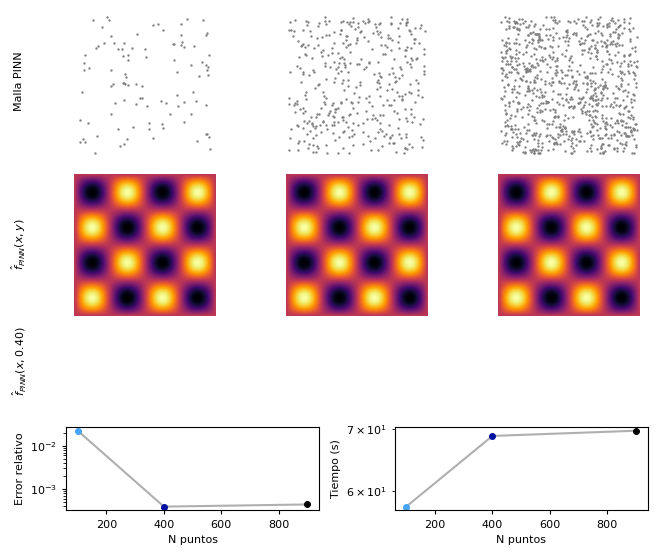

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import time
import pandas as pd
import os
import random
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# =====================================================
# 0. Fix reproducibility
# =====================================================
def set_seed(seed=42):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# =====================================================
# 1. Exact solution and RHS
# =====================================================
def f_exact(x, y):
    return np.sin(4 * np.pi * x) * np.sin(4 * np.pi * y)

def rhs(x, y):
    return -2 * (4 * np.pi)**2 * np.sin(4 * np.pi * x) * np.sin(4 * np.pi * y)

# =====================================================
# 2. Sine activation + Hard-constrained PINN
# =====================================================
class Sine(nn.Module):
    def forward(self, input):
        return torch.sin(input)

class PINN(nn.Module):
    def __init__(self, layers):
        super().__init__()
        layer_list = []
        for i in range(len(layers) - 1):
            layer_list.append(nn.Linear(layers[i], layers[i + 1]))
            if i < len(layers) - 2:
                layer_list.append(Sine())
        self.model = nn.Sequential(*layer_list)

    def forward(self, x, y):
        inputs = torch.cat([x, y], dim=1)
        u_hat = self.model(inputs)
        return x * (1 - x) * y * (1 - y) * u_hat  # Hard BCs (Dirichlet)

# =====================================================
# 3. Sampling points
# =====================================================
def sample_pinn_points(N_int, device="cpu"):
    eps = 1e-6
    x_int = eps + (1 - 2 * eps) * torch.rand((N_int, 1), device=device)
    y_int = eps + (1 - 2 * eps) * torch.rand((N_int, 1), device=device)
    x_int.requires_grad_(True)
    y_int.requires_grad_(True)
    return x_int, y_int

# =====================================================
# 4. Loss function
# =====================================================
def pinn_loss(model, x_int, y_int, device):
    f_pred = model(x_int, y_int)
    grads = torch.autograd.grad(f_pred, [x_int, y_int],
                                grad_outputs=torch.ones_like(f_pred),
                                create_graph=True)
    f_x, f_y = grads
    f_xx = torch.autograd.grad(f_x, x_int, torch.ones_like(f_x), create_graph=True)[0]
    f_yy = torch.autograd.grad(f_y, y_int, torch.ones_like(f_y), create_graph=True)[0]

    rhs_val = rhs(x_int.detach().cpu().numpy(), y_int.detach().cpu().numpy())
    rhs_torch = torch.tensor(rhs_val, dtype=torch.float32, device=device)

    res = f_xx + f_yy - rhs_torch
    return torch.mean(res ** 2)


In [36]:

# =====================================================
# 5. Training + evaluation loop
# =====================================================
def run_pinn_experiments(device="cpu", num_repeats=3, save_results=True):
    N_values = [100, 400, 900]
    layers = [2, 275, 275, 1]
    results = []
    os.makedirs("models", exist_ok=True)

    for N in N_values:
        print(f"\n=== Testing with {N} training points ===")
        train_times, eval_times, rel_errors = [], [], []

        for run in range(num_repeats):
            print(f"\n   Run {run + 1}/{num_repeats}")
            set_seed(42 + run)
            x_int, y_int = sample_pinn_points(N, device=device)

            model = PINN(layers).to(device)
            optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

            # ------------------------
            #  Training (Adam)
            # ------------------------
            print(f"--- Training (Adam) for N={N}, Run={run + 1} ---")
            t0 = time.time()
            for epoch in range(3000):
                optimizer.zero_grad()
                loss = pinn_loss(model, x_int, y_int, device)
                loss.backward()
                optimizer.step()
                if epoch % 500 == 0 or epoch == 2999:
                    print(f"Epoch {epoch:4d} | Loss = {loss.item():.6e}")
            t_adam = time.time() - t0

            # ------------------------
            #  Refinement (L-BFGS)
            # ------------------------
            optimizer_lbfgs = torch.optim.LBFGS(model.parameters(),
                                                max_iter=2000,
                                                tolerance_grad=1e-8,
                                                tolerance_change=1e-9,
                                                history_size=100,
                                                line_search_fn="strong_wolfe")

            def closure():
                optimizer_lbfgs.zero_grad()
                loss = pinn_loss(model, x_int, y_int, device)
                loss.backward()
                return loss

            t_lbfgs_start = time.time()
            optimizer_lbfgs.step(closure)
            t_train_total = t_adam + (time.time() - t_lbfgs_start)
            train_times.append(t_train_total)

            # ------------------------
            #  Evaluation
            # ------------------------
            nx, ny = 100, 100
            xg = np.linspace(0, 1, nx)
            yg = np.linspace(0, 1, ny)
            X, Y = np.meshgrid(xg, yg)
            XY_torch = torch.tensor(np.column_stack([X.flatten(), Y.flatten()]),
                                    dtype=torch.float32, device=device)

            t_eval_start = time.time()
            with torch.no_grad():
                f_pred = model(XY_torch[:, 0:1], XY_torch[:, 1:2]).cpu().numpy().reshape(ny, nx)
            t_eval = time.time() - t_eval_start
            eval_times.append(t_eval)

            f_true = f_exact(X, Y)
            error_rel = np.linalg.norm(f_pred - f_true, 2) / np.linalg.norm(f_true, 2)
            rel_errors.append(error_rel)
            print(f"      Run {run + 1}: Error = {error_rel:.3e}, Train = {t_train_total:.2f}s, Eval = {t_eval:.3f}s")

            # ------------------------
            # Save field for plots
            # ------------------------
            os.makedirs("data/pinn_fields", exist_ok=True)
            field_path = f"data/pinn_fields/pinn_field_N{N}_run{run+1}.npz"
            np.savez_compressed(field_path, X=X, Y=Y, f_pred=f_pred, f_true=f_true)
            print(f"      Saved field data → {field_path}")

            # Save model
            model_name = f"N_{N}_run{run + 1}.pt"
            torch.save(model.state_dict(), os.path.join("models", model_name))

        # Aggregate statistics
        mean_err, std_err = np.mean(rel_errors), np.std(rel_errors)
        mean_train, std_train = np.mean(train_times), np.std(train_times)
        mean_eval, std_eval = np.mean(eval_times), np.std(eval_times)
        best_idx = int(np.argmin(rel_errors))
        best_error = rel_errors[best_idx]

        result = {
            "N_points": N,
            "mean_rel_error": mean_err,
            "std_rel_error": std_err,
            "best_rel_error": best_error,
            "mean_train_time_s": mean_train,
            "std_train_time_s": std_train,
            "mean_eval_time_s": mean_eval,
            "std_eval_time_s": std_eval
        }
        results.append(result)

        print(f"   >> Avg Rel Error: {mean_err:.3e} ± {std_err:.1e}")
        print(f"   >> Avg Train Time: {mean_train:.2f} ± {std_train:.2f}s")

    if save_results:
        os.makedirs("data", exist_ok=True)
        df = pd.DataFrame(results)
        df.to_csv("data/pinn_helmholtz_experiment.csv", index=False)
        print("\nResults saved to data/pinn_helmholtz_experiment.csv")

    return results





=== Testing with 100 training points ===

   Run 1/1
--- Training (Adam) for N=100, Run=1 ---
Epoch    0 | Loss = 2.280414e+04
Epoch  500 | Loss = 2.172969e+04
Epoch 1000 | Loss = 1.280088e+04
Epoch 1500 | Loss = 4.126282e+03
Epoch 2000 | Loss = 2.345225e+03
Epoch 2500 | Loss = 1.487769e+03
Epoch 2999 | Loss = 1.029939e+03
      Run 1: Error = 1.209e-02, Train = 48.58s, Eval = 0.002s
      Saved field data → data/pinn_fields/pinn_field_N100_run1.npz
   >> Avg Rel Error: 1.209e-02 ± 0.0e+00
   >> Avg Train Time: 48.58 ± 0.00s

=== Testing with 400 training points ===

   Run 1/1
--- Training (Adam) for N=400, Run=1 ---
Epoch    0 | Loss = 2.252320e+04
Epoch  500 | Loss = 2.136361e+04
Epoch 1000 | Loss = 1.191778e+04
Epoch 1500 | Loss = 3.852114e+03
Epoch 2000 | Loss = 1.618556e+03
Epoch 2500 | Loss = 9.312222e+02
Epoch 2999 | Loss = 6.206257e+02
      Run 1: Error = 3.224e-04, Train = 68.83s, Eval = 0.001s
      Saved field data → data/pinn_fields/pinn_field_N400_run1.npz
   >> Avg Rel

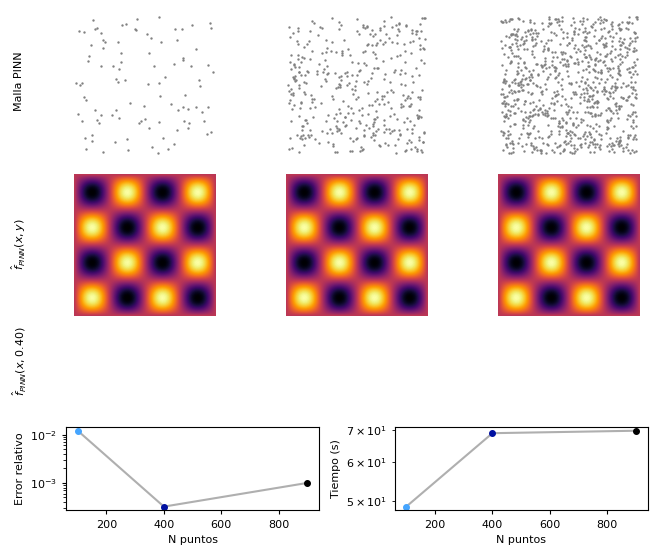

In [37]:
# =====================================================
# 6. Run experiments
# =====================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
results = run_pinn_experiments(device=device, num_repeats=1)



In [44]:
df

,N_points,mean_rel_error,std_rel_error,best_rel_error,mean_train_time_s,std_train_time_s,mean_eval_time_s,std_eval_time_s
0,100,0.012087,0.0,0.012087,48.575921,0.0,0.001503,0.0
1,400,0.000322,0.0,0.000322,68.825280,0.0,0.001005,0.0
2,900,0.001001,0.0,0.001001,69.631046,0.0,0.000948,0.0


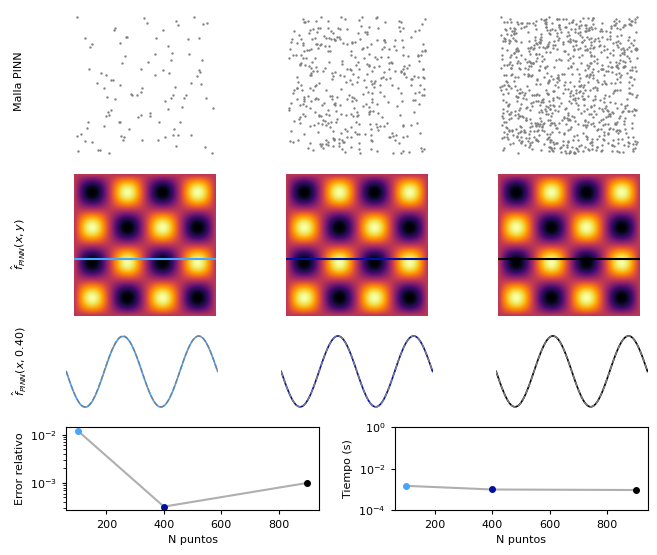

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from matplotlib.gridspec import GridSpec

# =====================================================
# 1. Load data
# =====================================================
df = pd.read_csv("data/pinn_helmholtz_experiment.csv")

# Limpieza y ordenamiento
idx_sorted = np.argsort(df["N_points"].values)
N_values = df["N_points"].values[idx_sorted]
relative_errors = df["mean_rel_error"].values[idx_sorted]
times = df["mean_eval_time_s"].fillna(0).values[idx_sorted]
times = np.maximum(times, 1e-6)  # evita ceros para escala log

# =====================================================
# 2. Load predicted and true fields
# =====================================================
results_dict = {}
for N in N_values:
    run_file = f"data/pinn_fields/pinn_field_N{N}_run1.npz"
    if os.path.exists(run_file):
        data = np.load(run_file)
        results_dict[N] = (data["X"], data["Y"], data["f_pred"], data["f_true"])

# =====================================================
# 3. Figure setup
# =====================================================
fig = plt.figure(figsize=(7.5, 6.5))
outer_gs = GridSpec(4, 1, height_ratios=[0.9, 0.85, 0.5, 0.5],
                    figure=fig, hspace=0.12)

colors = ['#45A5FF', "#0010A1", "#000000"]
N_examples = [100, 400, 900]

# =====================================================
# 4. Row 0: Training sample visualization
# =====================================================
gs_mesh = outer_gs[0].subgridspec(1, 3, wspace=0.35)
for i, N in enumerate(N_examples):
    ax = fig.add_subplot(gs_mesh[0, i])
    ax.scatter(np.random.rand(N), np.random.rand(N), color='tab:gray', s=0.5)
    ax.set_aspect("equal")
    ax.axis("off")
fig.text(0.055, 0.77, r"Malla PINN", fontsize=8, va="center", ha="left", rotation=90)

# =====================================================
# 5. Row 1: Predicted field
# =====================================================
gs_top = outer_gs[1].subgridspec(1, 3, wspace=0.35)
for i, (N, color) in enumerate(zip(N_examples, colors)):
    ax = fig.add_subplot(gs_top[0, i])
    X, Y, F_pred, _ = results_dict[N]
    ax.imshow(F_pred.T, extent=(0,1,0,1), cmap="inferno", vmin=-1, vmax=1,
              origin="lower", interpolation="bilinear")
    y_line = 0.4
    ax.axhline(y_line, color=color, lw=1.5)
    ax.set_aspect("equal")
    ax.axis("off")
fig.text(0.05, 0.52, r"$\hat{f}_{PINN}(x,y)$", fontsize=8, va="center", ha="left", rotation=90)

# =====================================================
# 6. Row 2: Slice comparison
# =====================================================
gs_mid = outer_gs[2].subgridspec(1, 3, wspace=0.42)
for i, (N, color) in enumerate(zip(N_examples, colors)):
    ax = fig.add_subplot(gs_mid[0, i])
    X, Y, F_pred, F_true = results_dict[N]
    idx = np.argmin(np.abs(Y[:, 0] - 0.4))
    ax.plot(X[idx, :], F_pred[idx, :], '-', color=color, lw=1.2, label="PINN")
    ax.plot(X[idx, :], F_true[idx, :], '--', color='tab:gray', lw=1, label="Exact")
    ax.set_xlim(0, 1)
    ax.set_ylim(-1.1, 1.1)
    ax.axis("off")
fig.text(0.05, 0.34, r"$\hat{f}_{PINN}(x,0.40)$", fontsize=8, va="center", ha="left", rotation=90)

# =====================================================
# 7. Row 3: Errors and times
# =====================================================
gs_bottom = outer_gs[3].subgridspec(1, 2, wspace=0.3)
ax_errN = fig.add_subplot(gs_bottom[0, 0])
ax_errT = fig.add_subplot(gs_bottom[0, 1])

# --- Error vs N ---
ax_errN.plot(N_values, relative_errors, '.-', color='#AFAFAF')
for N, color in zip(N_examples, colors):
    idx = np.where(N_values == N)[0][0]
    ax_errN.plot(N_values[idx], relative_errors[idx], '.', color=color, markersize=8)
ax_errN.set_xlabel("N puntos")
ax_errN.set_ylabel("Error relativo")
ax_errN.set_yscale("log")

# --- Tiempo vs N ---
ax_errT.plot(N_values, times, '.-', color='#AFAFAF')
for N, color in zip(N_examples, colors):
    idx = np.where(N_values == N)[0][0]
    ax_errT.plot(N_values[idx], times[idx], '.', color=color, markersize=8)
ax_errT.set_xlabel("N puntos")
ax_errT.set_ylabel("Tiempo (s)")
ax_errT.set_yscale("log")
 
ax_errT.set_ylim(top=1e0, bottom=1e-4)
# =====================================================
# 8. Save and show figure
# =====================================================
os.makedirs("figs", exist_ok=True)
plt.savefig("figs/pinn_helmholtz2D_convergence.svg", dpi=150, bbox_inches="tight")
plt.show()
